# **Actividad Fundamental N.º 3 - Producto Integrador de Aprendizaje**

## **Instalación de las librerias y la base de datos**

In [22]:
import os
import cv2 #    Módulo para analizar las imágenes
import pandas as pd #   Se utiliza para menejar y analizar los dataframes
import numpy as np #    Para las operaciones matemáticas y trabajar con los arrays
import tensorflow as tf #   Se utiliza, en este caso, para el preprocesamiento de las imágenes
import matplotlib.pyplot as plt #   Ayuda a generar gráficos
import seaborn as sns   #   Esta librería la utilizamos para generar el heatmap de la matríz de confusión

#   Se importan las funciones de Sikit_Learn necesarias para entrenar el modelo y sacar las métricas que evaluan el rendimiento del modelo
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [ ]:
# importar google drive
from google.colab import drive
drive.mount("/content/drive")

# Ruta del dataset
FUENTE = "/content/drive/MyDrive/Programación/PIA/Frutas"

assert os.path.isdir(FUENTE), "Revisa la ruta"
print("Contenido del dataset:")
print(os.listdir(FUENTE))

In [ ]:
#   Diccionario para cambiar el nombre de las etiquetas a uno más simple y en español
frutas = {'apple fruit' : "Manzana", 'kiwi fruit' : "Kiwi", 'strawberry fruit' : "Fresa", 'cherry fruit' : "Cereza", 'chickoo fruit' : "Sapote", 'orange fruit' : "Naranja", 'grapes fruit' : "Uva", 'mango fruit' : "Mango", 'banana fruit' : "Platano"}

#   Listas para almacenar la ruta y etiqueta correspondiente a cada imagen
filepaths = []
labels = []

#   Ciclo for que se encarga de revisar cada una de las imágenes
for folder_name, class_label in frutas.items():
    folder_path = os.path.join(FUENTE, folder_name)

    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if os.path.isfile(fpath):   #   Agrega la ruta y etiqueta a su lista correspondiente
            filepaths.append(fpath)
            labels.append(class_label)

#   Genera un DataFrame con las listas ya generadas
data_df = pd.DataFrame({"filepath" : filepaths, "label" : labels})
data_df["label"].value_counts() #   Muestra la cantidad de imágenes que hay por etiqueta

In [14]:
#   Función para revisar cada una de las imágenes y revisar si es válida o no
def is_valid_image(path):
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return False
        _ = img.shape
        return True
    except Exception:
        return False

#   Se aplica la función a cada imágen
valid_mask = data_df["filepath"].apply(is_valid_image)
invalid_count = (-valid_mask).sum() #   Se hace una suma de las imágenes invalidas
print("Imágenes invalidas detectadas: ", invalid_count)

#   Se quitan las imágenes inválidas del dataset y se muestra la cantidad de imágenes válidas
data_df = data_df[valid_mask].reset_index(drop = True)
print("Total de imagenes validas", len(data_df))
data_df["label"].value_counts()

Imágenes invalidas detectadas:  0
Total de imagenes validas 360


,count
label,
Manzana,40
Kiwi,40
Fresa,40
Cereza,40
Sapote,40
Naranja,40
Uva,40
Mango,40
Platano,40


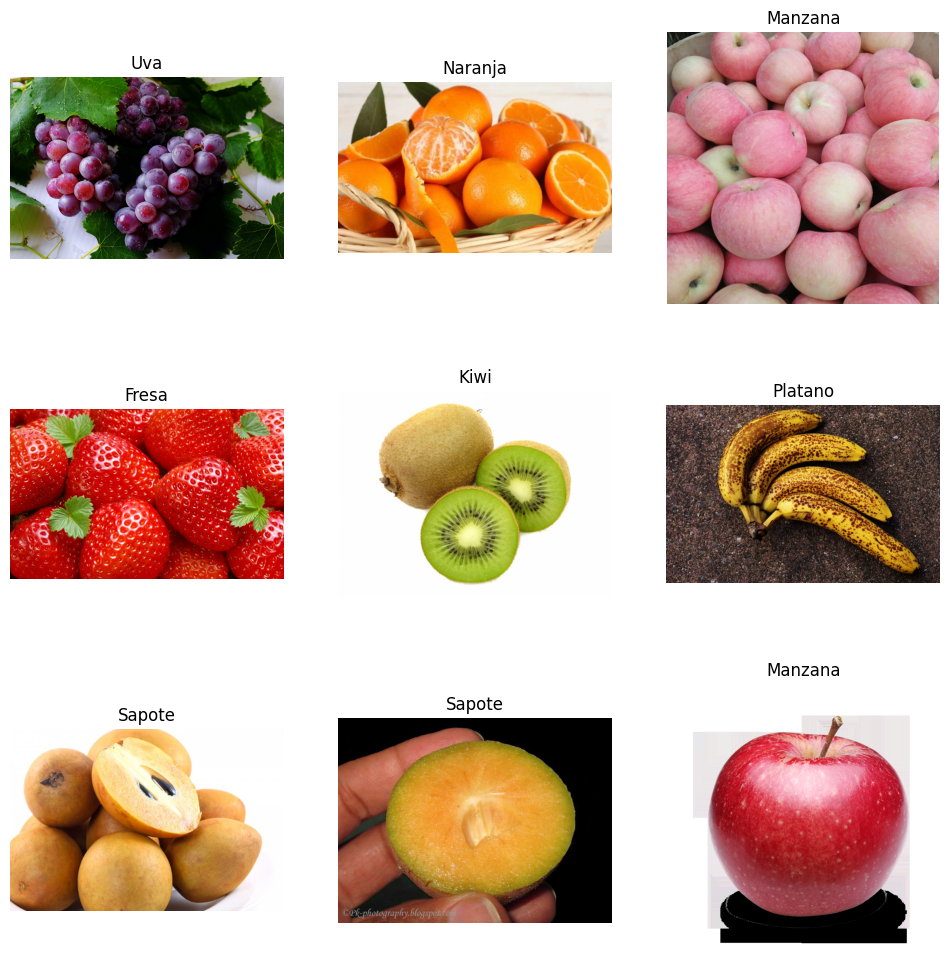

In [15]:
plt.figure(figsize=(12, 12))

# Select 9 random indices from the DataFrame
random_img= np.random.choice(data_df.index, size=9, replace=False)

# Iterate over the randomly selected rows
for i, idx in enumerate(random_img):
    row = data_df.loc[idx]
    filepath = row["filepath"]
    label = row["label"]

    plt.subplot(3, 3, i + 1)

    # Load the image using OpenCV
    img = cv2.imread(filepath)

    if img is not None:
        # Convert BGR image (OpenCV default) to RGB for matplotlib display
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label)  # Display the label as the title for the subplot
    else:
        # Handle cases where image might not load
        plt.text(0.5, 0.5, "Image not loaded", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.axis("off")
plt.show()

In [20]:
TAMAÑO = 224
imagenes_procesadas = []

for imagen in data_df["filepath"]:
    img = tf.io.read_file(imagen)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, [TAMAÑO, TAMAÑO])
    img = img / 255
    imagenes_procesadas.append(img)

X = np.array(imagenes_procesadas)

# Convertir las etiquetas de string a numéricas
labels_numeric, unique_labels = pd.factorize(data_df["label"])
Y = np.array(labels_numeric)

# 1. Aplanar las imágenes (Flatten)
# Scikit-learn no acepta matrices 3D, necesita 2D (muestras, características)
# Convertimos de (Cantidad, 224, 224, 3) a (Cantidad, 150528)
nsamples, nx, ny, nrgb = X.shape
X_flatten = X.reshape((nsamples, nx*ny*nrgb))

# 2. Split usando X_flatten (el aplanado) en lugar de X normal
X_train, X_test, Y_train, Y_test = train_test_split(X_flatten, Y, test_size = 0.3, random_state = 42)

print("Tamaño del set de entrenamiento aplanado:", X_train.shape)
print("Tamaño del set de prueba aplanado:", X_test.shape)

Tamaño del set de entrenamiento aplanado: (252, 150528)
Tamaño del set de prueba aplanado: (108, 150528)


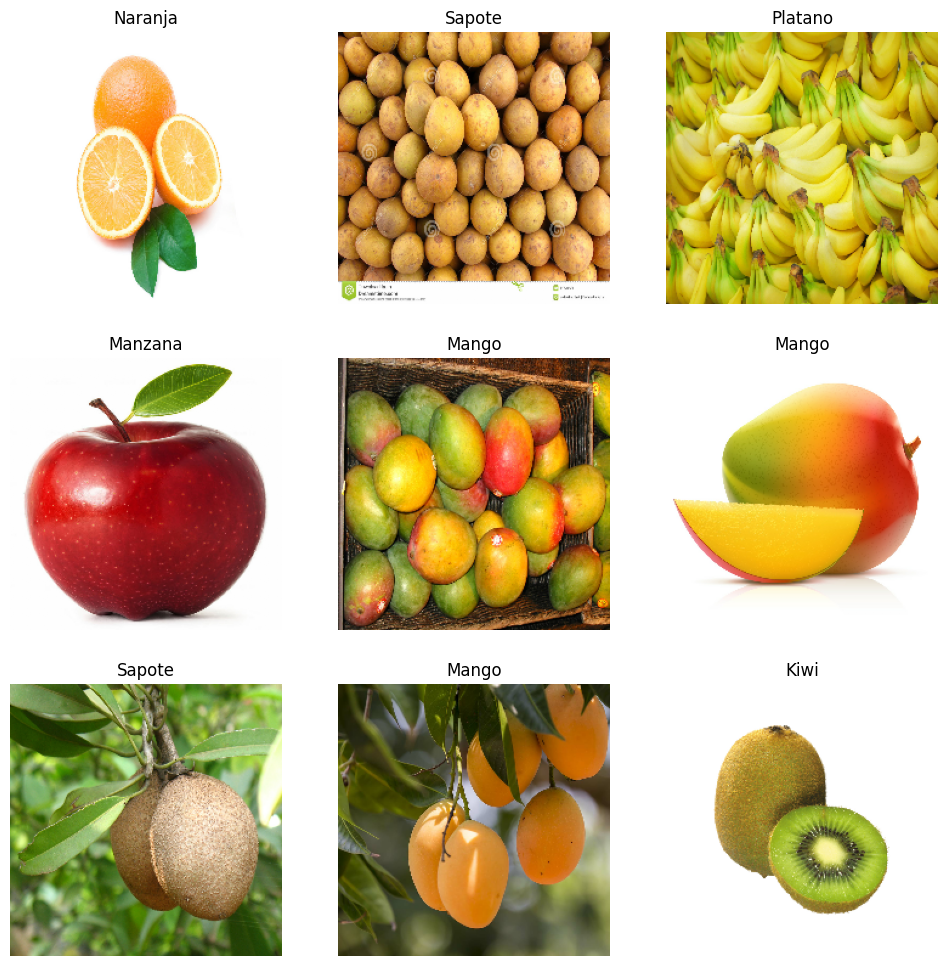

In [17]:
plt.figure(figsize=(12, 12))

# Select 9 random indices from the DataFrame to get corresponding normalized images and labels
random_indices = np.random.choice(len(X), size=9, replace=False)

# Iterate over the randomly selected indices
for i, idx in enumerate(random_indices):
    # Get the normalized image from X
    img_normalized = X[idx]
    # Get the original label from data_df using the same index
    label = data_df.loc[idx, "label"]

    plt.subplot(3, 3, i + 1)

    # Display the normalized image. No need for cvtColor as X is already RGB.
    plt.imshow(img_normalized)
    plt.title(label)  # Display the label as the title for the subplot

    plt.axis("off")
plt.show()

In [18]:
#Convertir las etiquetas a numéricas
labels_numeric, unique_labels = pd.factorize(data_df["label"])

# Seleccionar 10 índices aleatorios
random_indices = np.random.choice(len(data_df), size=10, replace=False)

# Mostrar 10 etiquetas originales y sus correspondientes etiquetas numéricas de forma aleatoria
print("Etiquetas originales (10 ejemplos aleatorios):")
print(data_df["label"].iloc[random_indices].to_list())
print("\nEtiquetas numéricas (10 ejemplos aleatorios):")
print(labels_numeric[random_indices].tolist())

print("\nCorrespondencia de etiquetas numéricas a nombres:")
for i, label_name in enumerate(unique_labels):
    print(f"  {label_name}: {i}")

Etiquetas originales (10 ejemplos aleatorios):
['Naranja', 'Mango', 'Platano', 'Kiwi', 'Mango', 'Uva', 'Mango', 'Cereza', 'Manzana', 'Uva']

Etiquetas numéricas (10 ejemplos aleatorios):
[5, 7, 8, 1, 7, 6, 7, 3, 0, 6]

Correspondencia de etiquetas numéricas a nombres:
  Manzana: 0
  Kiwi: 1
  Fresa: 2
  Cereza: 3
  Sapote: 4
  Naranja: 5
  Uva: 6
  Mango: 7
  Platano: 8


In [25]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

modelo = LogisticRegression(multi_class='multinomial', max_iter=1000)
modelo.fit(X_train_flat, Y_train)

predicciones = modelo.predict(X_test_flat)
pd.DataFrame(confusion_matrix(Y_test, predicciones), columns=unique_labels, index=unique_labels)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Manzana,Kiwi,Fresa,Cereza,Sapote,Naranja,Uva,Mango,Platano
Manzana,5,1,2,3,1,0,0,1,0
Kiwi,0,5,0,1,6,0,2,0,1
Fresa,0,1,7,0,1,3,1,0,0
Cereza,1,2,1,8,1,0,0,0,0
Sapote,1,2,0,0,1,0,1,1,2
Naranja,2,0,0,1,0,8,0,2,1
Uva,0,0,0,0,1,1,2,1,0
Mango,0,1,0,0,2,5,1,3,1
Platano,0,0,0,0,2,3,1,1,7


--- Métricas de Evaluación ---
Accuracy (Exactitud): 0.42592592592592593

Reporte de Clasificación Completo:
              precision    recall  f1-score   support

     Manzana       0.56      0.38      0.45        13
        Kiwi       0.42      0.33      0.37        15
       Fresa       0.70      0.54      0.61        13
      Cereza       0.62      0.62      0.62        13
      Sapote       0.07      0.12      0.09         8
     Naranja       0.40      0.57      0.47        14
         Uva       0.25      0.40      0.31         5
       Mango       0.33      0.23      0.27        13
     Platano       0.58      0.50      0.54        14

    accuracy                           0.43       108
   macro avg       0.44      0.41      0.41       108
weighted avg       0.47      0.43      0.44       108



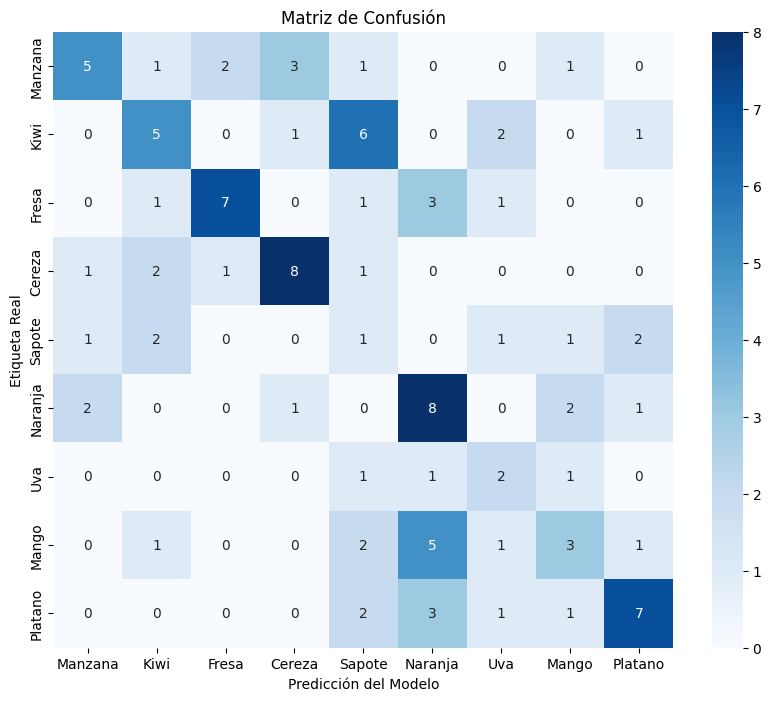

In [23]:
# 1. Métricas numéricas
print("--- Métricas de Evaluación ---")
print("Accuracy (Exactitud):", accuracy_score(Y_test, predicciones))
print("\nReporte de Clasificación Completo:")
# target_names pone los nombres de los animales en lugar de números 0,1,2,3
print(classification_report(Y_test, predicciones, target_names=unique_labels))

# 2. Gráfica de la Matriz de Confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_test, predicciones)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Modelo')
plt.title('Matriz de Confusión')
plt.show()